In [1]:
import pandas as pd
import numpy as np

import argparse

import seaborn as sns

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# SHAP
import shap

# LIME
from lime.lime_tabular import LimeTabularExplainer

# ICE
from sklearn.inspection import PartialDependenceDisplay



In [2]:
def read_any(file, header):
    if file.endswith('.csv') or file.endswith('.tsv'):
        if header:
            df = pd.read_csv(file, header=0)
        else:
            df = pd.read_csv(file)
    elif file.endswith('.json'):
        df = pd.read_json(file)
    elif file.endswith('.xml'):
        df = pd.read_xml(file)
    elif file.endswith('.xls') or file.endswith('.xlsx'):
        df = pd.read_excel(file)
    elif file.endswith('.hdf'):
        df = pd.read_hdf(file)
    elif file.endswith('.sql'):
        df = pd.read_sql(file)
    else:
        raise ValueError(f'Unsupported filetype: {file}')
    return df

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('data', help='path to the file with dataset')
parser.add_argument('target', help='index of the target column', type=int)
parser.add_argument('--header', action='store_true')
parser.add_argument('--model')

args = parser.parse_args(['diabetes_binary_health_indicators_BRFSS2021.csv', '0', '--header', '--model', 'model.cbm'])

In [8]:
from sklearn.datasets import load_breast_cancer
ds = load_breast_cancer()
data = ds['data']
target = ds['target']
feature_names = ds['feature_names']

data = pd.DataFrame(data, columns=feature_names)
target = pd.DataFrame(target)

In [5]:
data = read_any(args.data, args.header)
target_idx = args.target
target = data.iloc[:, target_idx]
data = data.drop(columns=data.columns[target_idx])
_, data, _, target = train_test_split(data, target, test_size=800, stratify=target)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target)

In [10]:
data.shape, target.shape

((569, 30), (569, 1))

In [22]:
class DatasetExplorer:
    def __init__(self, data: pd.DataFrame, target: pd.Series):
        self._data = data
        self._target = target

    def _corr(self):
        return data.corr(), data.corrwith(target.squeeze())

    def display(self):
        features_corr, target_corr = self._corr()
        sns.heatmap(features_corr)
        plt.title('Features collinearity')
        plt.show()

        target_corr.plot(kind='bar', title='Correlation with target')
        plt.show()

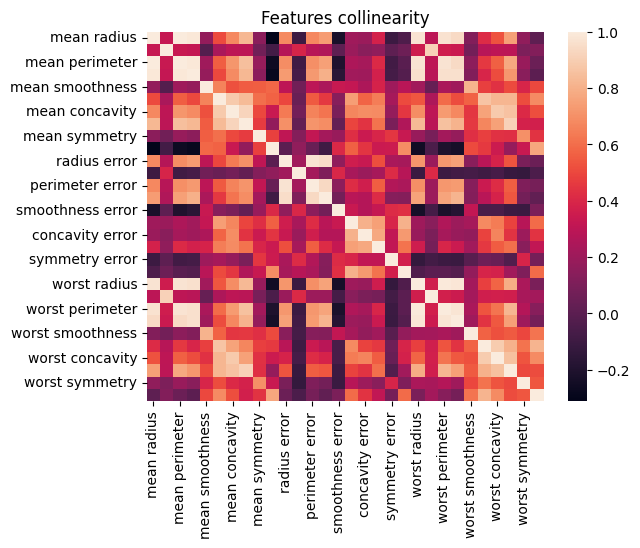

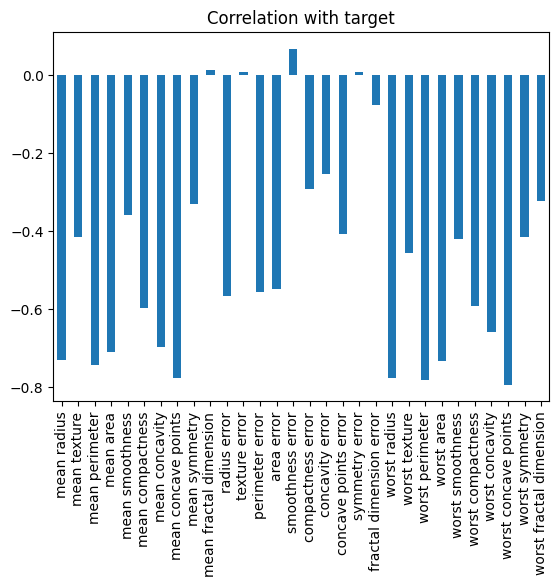

In [23]:
de = DatasetExplorer(data, target)
de.display()

In [16]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model_params = {
    'eval_metric': 'F1',
    'custom_metric': ['Accuracy', 'Precision', 'Recall'],
}

In [ ]:
grid_params = {
    'iterations': np.linspace(1000, 3000, 2, dtype=int),
    'learning_rate': np.logspace(-2, 0, 2),
    'l2_leaf_reg': np.logspace(-2, 1, 2)
}

model = CatBoostClassifier(**model_params, logging_level='Silent')
cv = model.grid_search(grid_params, train_pool, plot=True, verbose=False)
params, cv_results = cv['params'], cv['cv_results']

In [17]:
params = {'iterations': 3000, 'learning_rate': 0.5, 'l2_leaf_reg': 1}

In [18]:
params = {**model_params, **params, 'auto_class_weights': 'Balanced'}

final_model = CatBoostClassifier(**params)
final_model.fit(train_pool, eval_set=test_pool, silent=True)

---

In [ ]:
class ModelEvaluator:
    def __init__(self, model):
        self._model = model

    def confusion_matrix(self, X_test, y_test):
        confusion = confusion_matrix(y_test, final_model.predict(X_test))
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
        disp.plot()
        plt.show()

    def calc_metric_folded(clf, X_test, y_test, metric, n_folds=5):
        scores = []
        for X_test_fold, y_test_fold in zip(np.array_split(X_test, n_folds), np.array_split(y_test, n_folds)):
            scores.append(metric(y_test_fold, clf.predict(X_test_fold)))
        return np.array(scores)

---

In [20]:
def calc_metric_folded(clf, X_test, y_test, metric, n_folds=5):
    scores = []
    for X_test_fold, y_test_fold in zip(np.array_split(X_test, n_folds), np.array_split(y_test, n_folds)):
        scores.append(metric(y_test_fold, clf.predict(X_test_fold)))
    return np.array(scores)

In [21]:
calc_metric_folded(final_model, X_test, y_test, f1_score).std()

0.01636322629449012

---

In [ ]:
class ModelExplainer:
    def __init__(self, model, data):
        self._model = model
        self._data = data


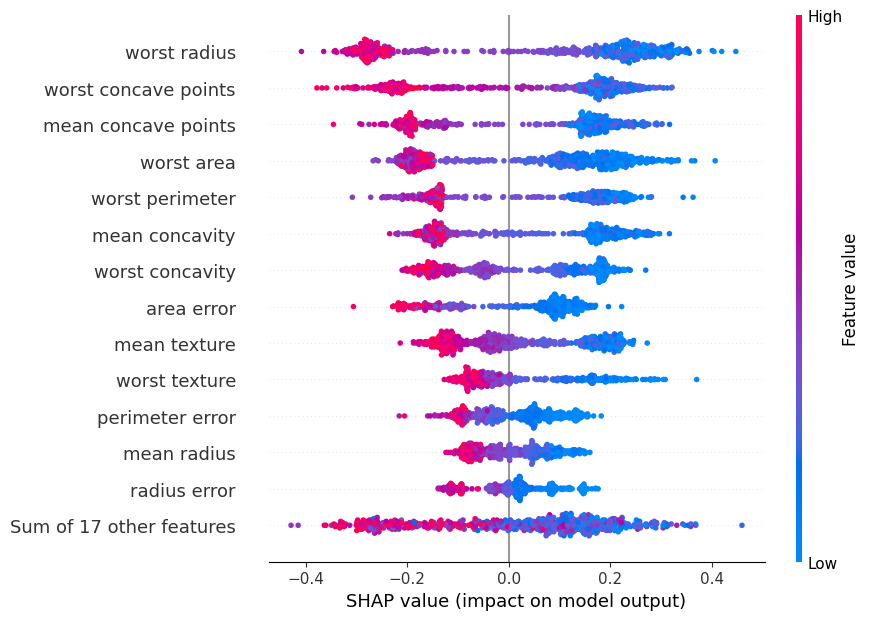

In [37]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(data)

shap.plots.beeswarm(shap_values, max_display=14)

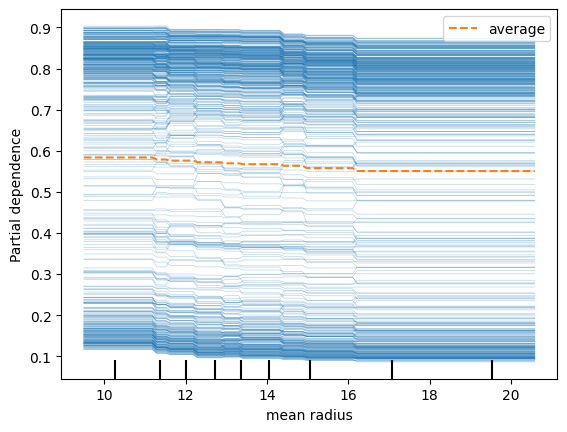

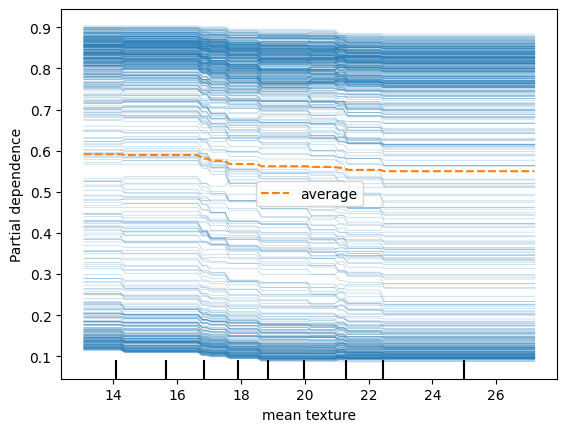

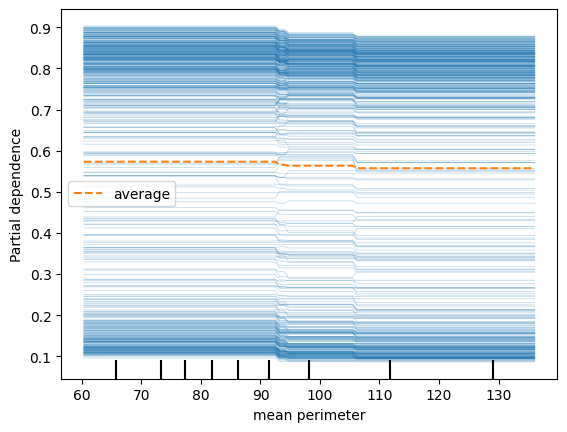

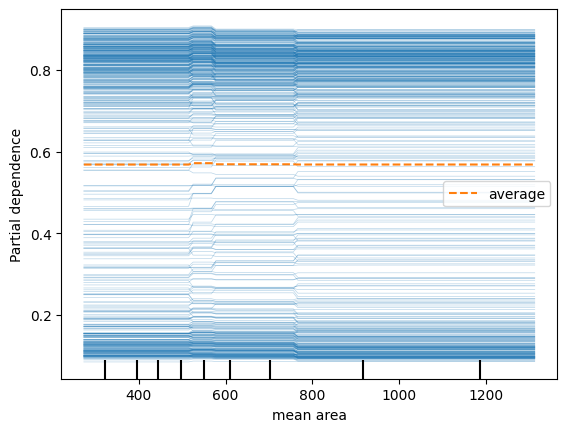

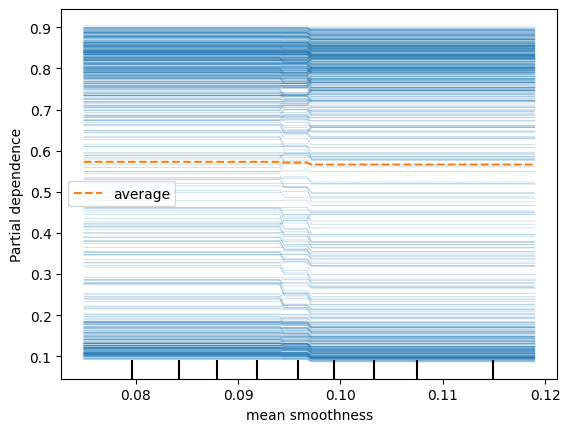

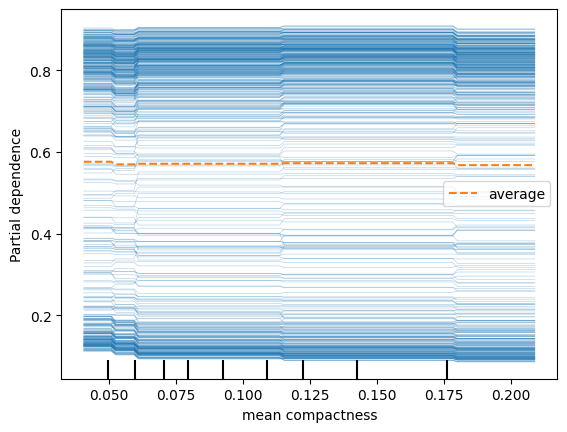

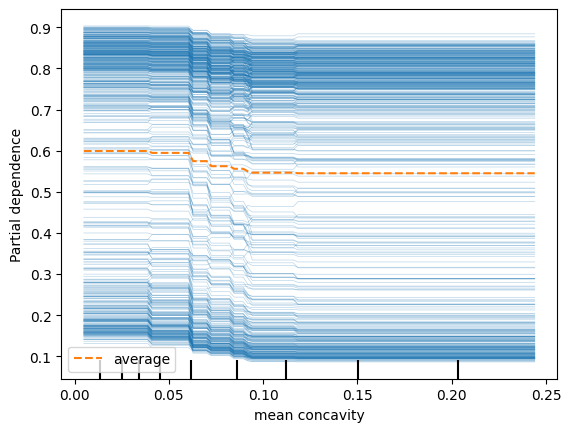

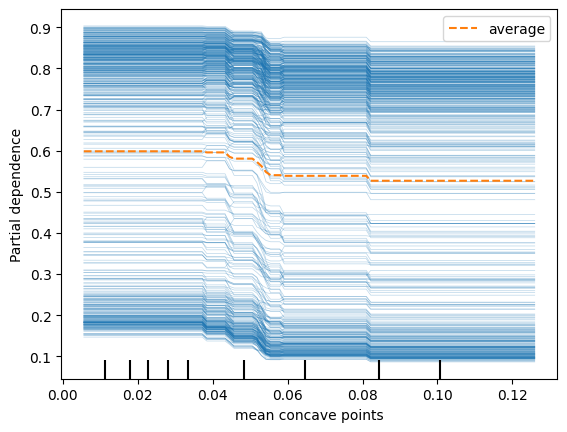

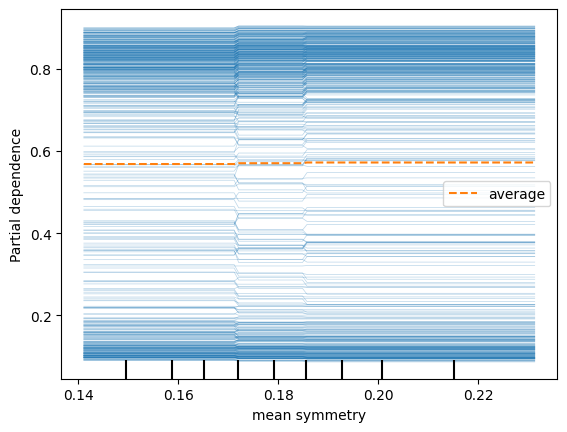

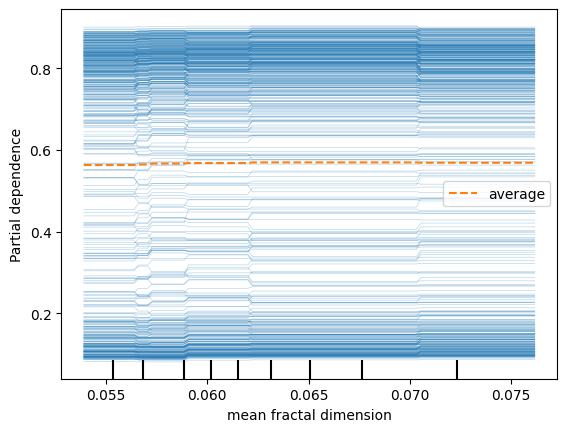

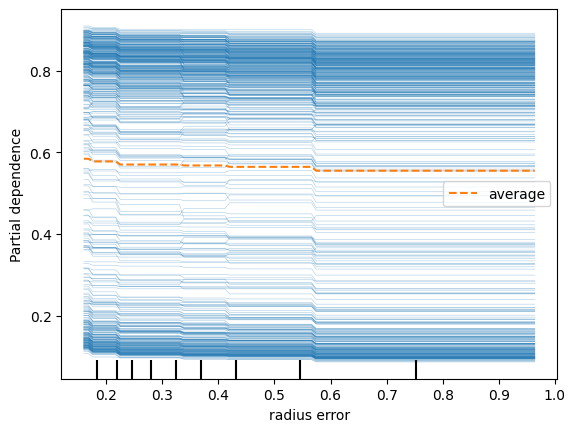

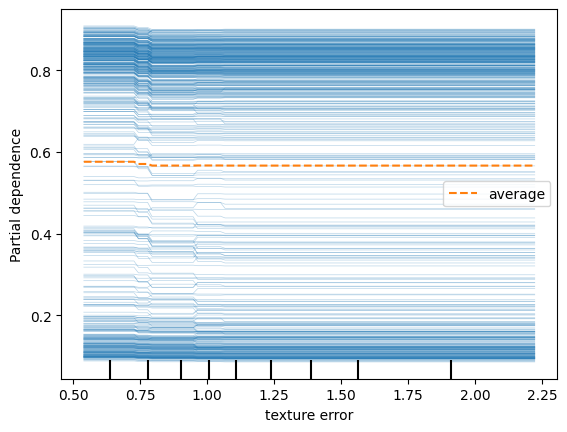

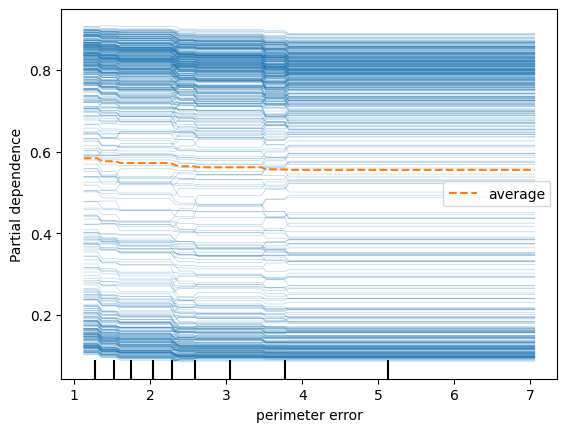

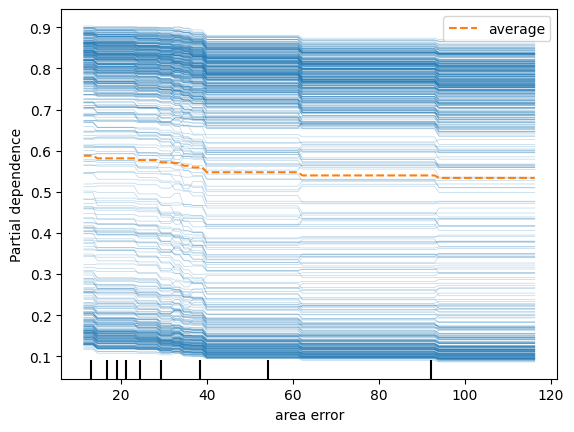

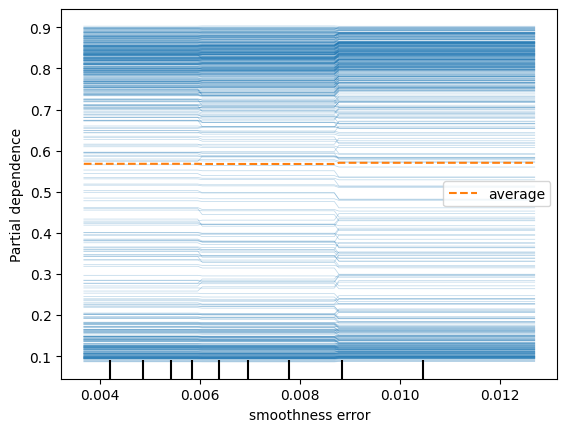

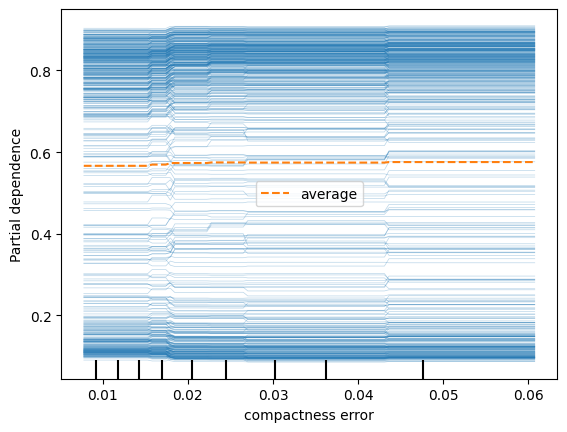

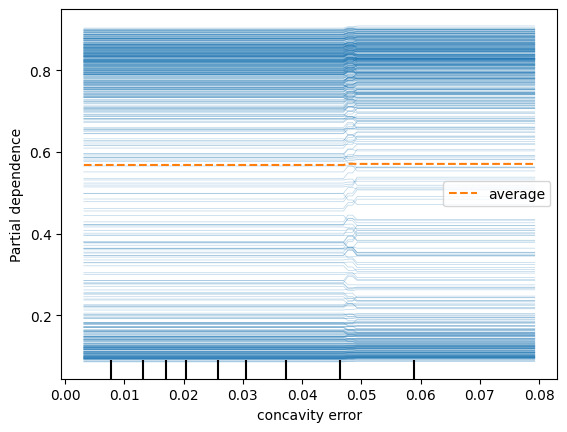

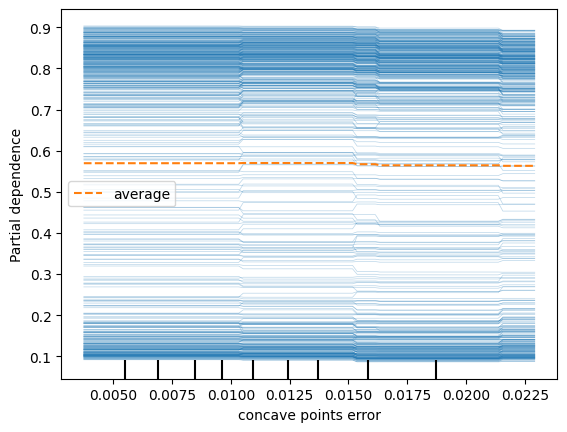

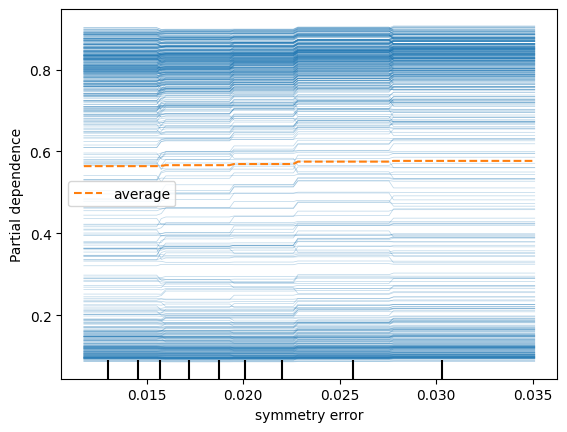

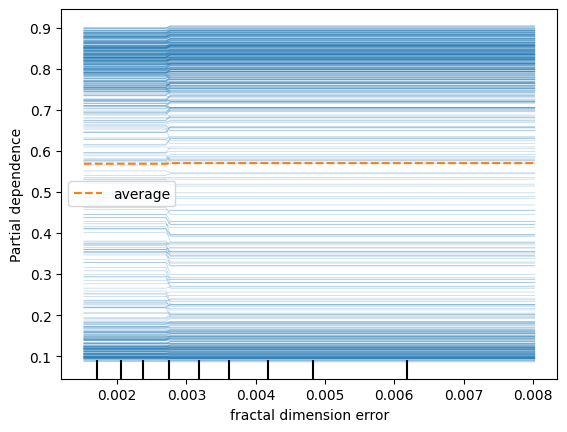

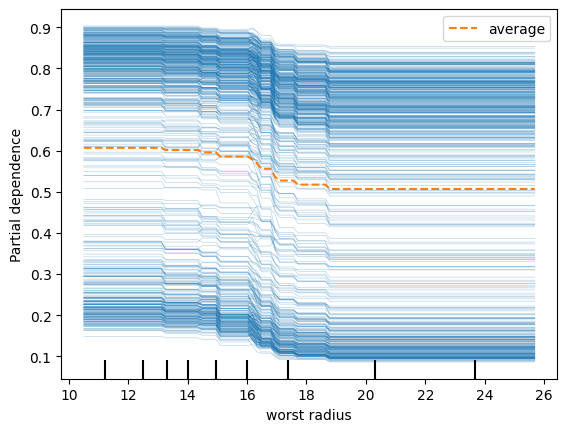

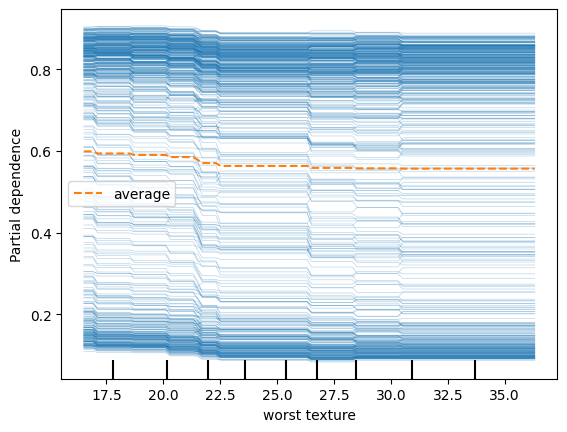

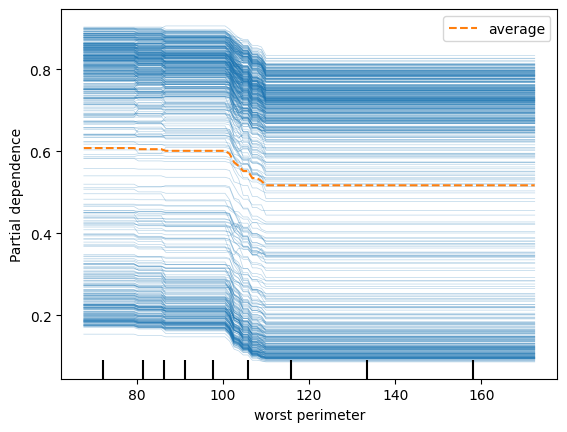

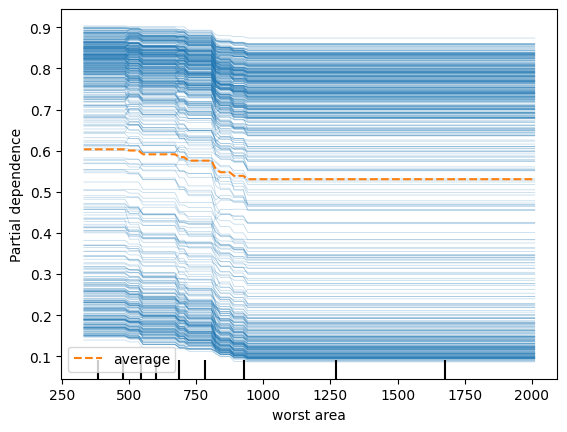

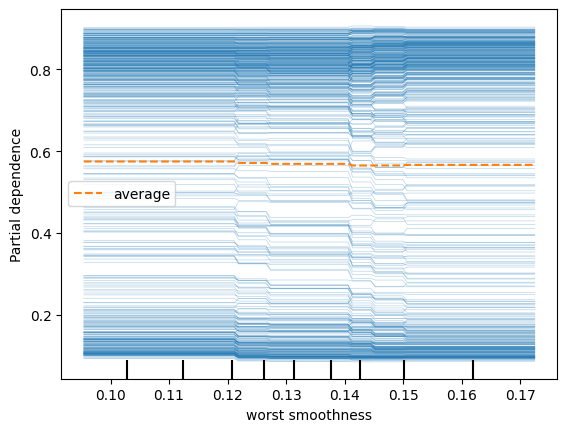

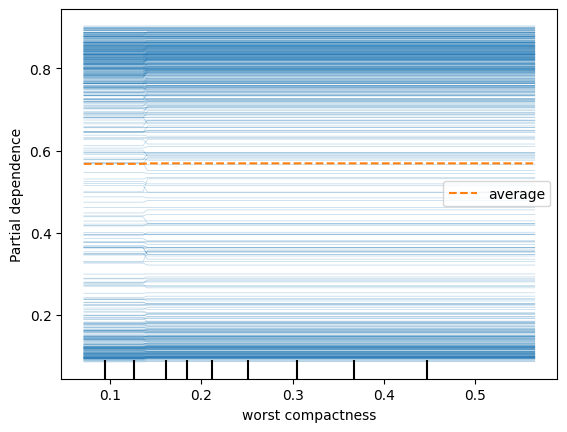

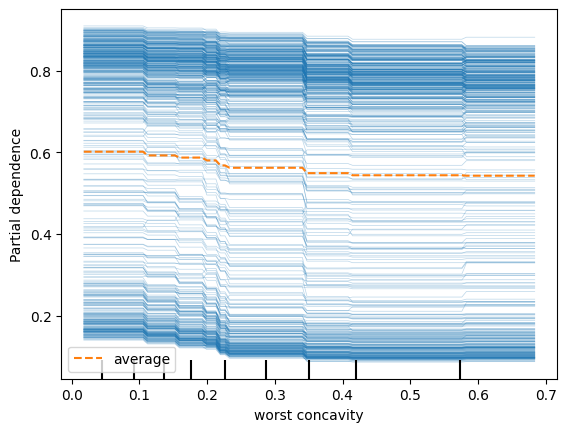

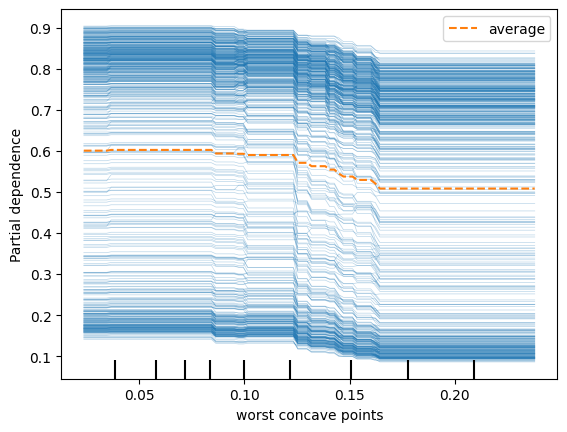

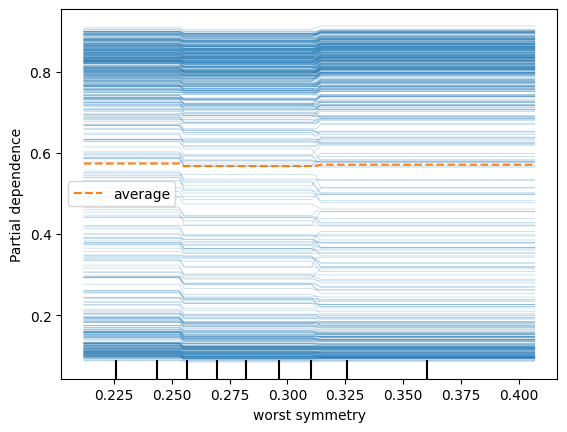

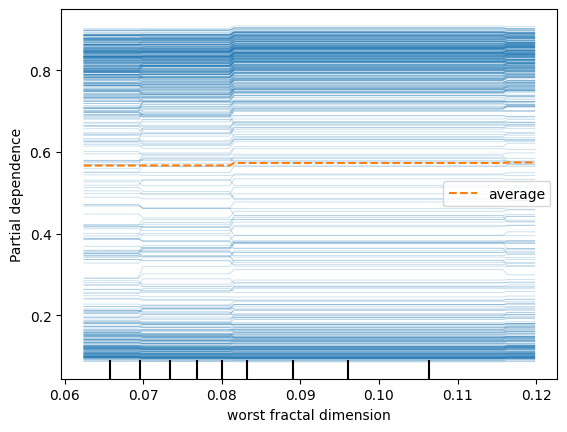

In [50]:
# ICE
for i in range(data.shape[1]):
    PartialDependenceDisplay.from_estimator(final_model, data, [i], kind='both')
    plt.show()

In [62]:
# LIME
explainer = LimeTabularExplainer(data.to_numpy(), feature_names=data.columns.values, discretize_continuous=True)



---

In [29]:
class VirtualDataset:
    def __init__(self, model_class, model_params, eval_metric, n_iter=5,):
        self._Model = model_class
        self._params = model_params
        self._metric = eval_metric
        self._max_iter = n_iter
        self._sizes = np.linspace(0.2, 1, self._max_iter)

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        self._X_train = X_train
        self._X_test = X_test
        self._y_train = y_train
        self._y_test = y_test

        sizes = []
        scores = []
        for i, size in enumerate(self._sizes):
            for _ in range(5):
                if size != 1:
                    X, _, y, _ = train_test_split(self._X_train, self._y_train, test_size=1-size, stratify=self._y_train)
                else:
                    X, y = self._X_train, self._y_train
                model = self._Model(**self._params)
                model.fit(X, y)
                score = self._metric(model.predict(self._X_test), self._y_test)
                sizes.append(len(X))
                scores.append(score)

        return {'DatasetSize': sizes, 'Score': scores}

In [30]:
vds = VirtualDataset(CatBoostClassifier, model_params | {'silent': True}, f1_score, n_iter=10)
vds_res = vds.fit(data.to_numpy(), target.to_numpy())

<Axes: xlabel='DatasetSize', ylabel='Score'>

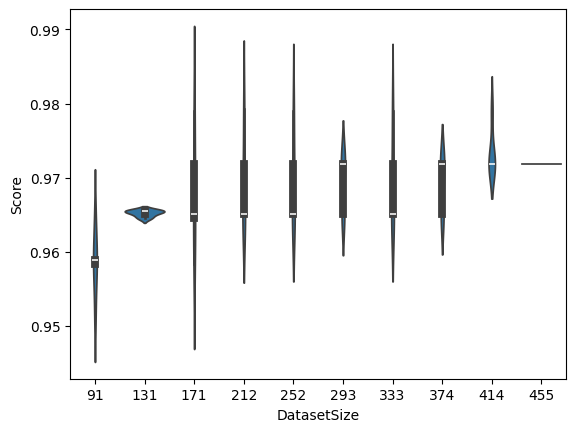

In [33]:
sns.violinplot(vds_res, x='DatasetSize', y='Score')

---